In [3]:
import zipfile
import os


with zipfile.ZipFile("/content/GPUPy.zip", 'r') as zip_ref:
    zip_ref.extractall("/content/")


os.listdir("/content/")

['.config', 'GPUPy.zip', 'GPUPy', 'sample_data']

In [4]:
os.listdir("/content/")

import sys
sys.path.append("/content")

GPU is available. Found 1 device(s).
Running GPU vs CPU Benchmark for Numerical Differentiation
------------------------------------------------------------
Size         CPU Time (s)    GPU Time (s)    Speedup   
------------------------------------------------------------
100,000      0.000228        0.001011        0.23      x
1,000,000    0.006079        0.003986        1.53      x
5,000,000    0.033266        0.029632        1.12      x
10,000,000   0.064905        0.054309        1.20      x


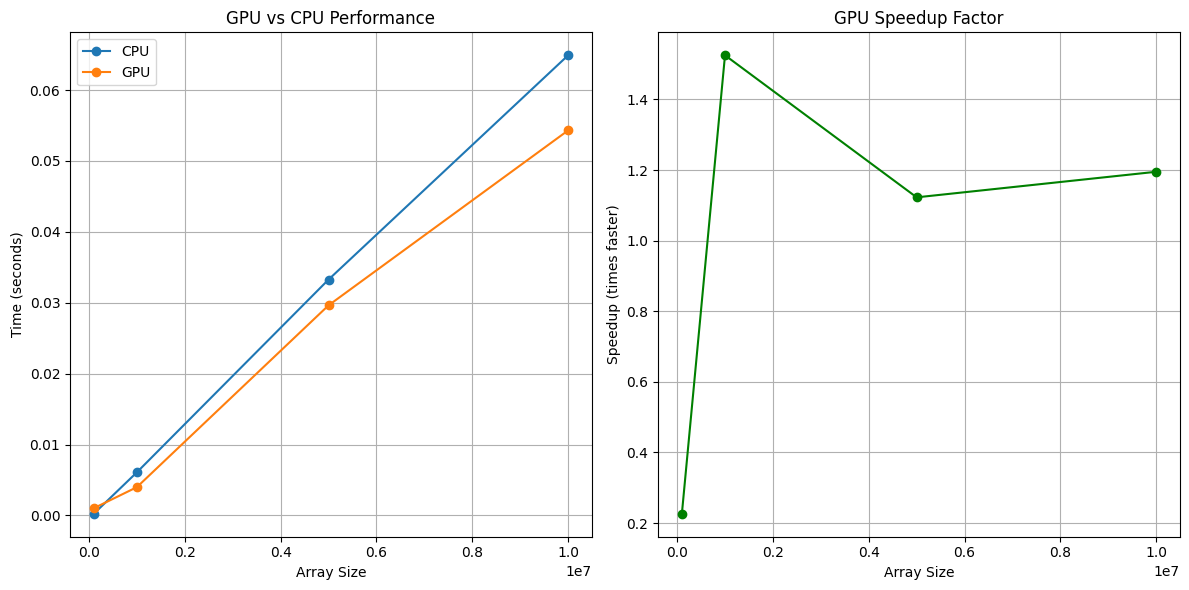

In [11]:
import numpy as np
import cupy as cp
import time
import matplotlib.pyplot as plt

# Define correct differentiation functions
def forward_diff(data, dx=1.0):
    """Forward difference method for array data."""
    result = np.zeros_like(data)
    result[:-1] = (data[1:] - data[:-1]) / dx
    result[-1] = result[-2]  # Handle boundary
    return result

def backward_diff(data, dx=1.0):
    """Backward difference method for array data."""
    result = np.zeros_like(data)
    result[1:] = (data[1:] - data[:-1]) / dx
    result[0] = result[1]  # Handle boundary
    return result

def central_diff(data, dx=1.0):
    """Central difference method for array data."""
    result = np.zeros_like(data)
    result[1:-1] = (data[2:] - data[:-2]) / (2 * dx)
    result[0] = (data[1] - data[0]) / dx  # Forward diff for first point
    result[-1] = (data[-1] - data[-2]) / dx  # Backward diff for last point
    return result

# GPU support
def gradient_gpu(data, dx=1.0):
    """GPU-accelerated gradient computation."""
    data_gpu = cp.asarray(data)
    result_gpu = cp.gradient(data_gpu, dx)
    return cp.asnumpy(result_gpu)

# Compute derivative function
def compute_derivative(data, dx=1.0, method='auto', use_gpu=False):
    """
    Compute derivative of input data using different methods.

    Parameters:
        data: array-like
        dx: step size (default: 1.0)
        method: 'auto', 'forward', 'backward', 'central'
        use_gpu: True to use GPU-accelerated version if available
    Returns:
        Approximate derivative
    """
    if use_gpu:  # GPU integration
        return gradient_gpu(data, dx)
    if method == 'auto':
        return np.gradient(data, dx)
    elif method == 'forward':
        return forward_diff(data, dx)
    elif method == 'backward':
        return backward_diff(data, dx)
    elif method == 'central':
        return central_diff(data, dx)
    else:
        raise ValueError("Invalid method. Choose 'auto', 'forward', 'backward', or 'central'.")

# Benchmark function
def my_benchmark(method_func, *args, repeats=5, **kwargs):
    """
    Measure the execution time of a method.

    Parameters:
        method_func: function to measure
        *args: positional arguments to pass to method
        repeats: number of times to repeat the measurement
        **kwargs: keyword arguments to pass to method

    Returns:
        Average execution time
    """
    # Initial call to validate (not timed)
    method_func(*args, **kwargs)

    # Now time the method calls
    durations = []
    for _ in range(repeats):
        start = time.perf_counter()
        method_func(*args, **kwargs)
        durations.append(time.perf_counter() - start)

    avg_time = sum(durations) / repeats
    return avg_time

def run_gpu_cpu_comparison():
    # Test functions
    def complex_func(x):
        return x**3 - 5*x**2 + 6*x - 2

    sizes = [100_000, 1_000_000, 5_000_000, 10_000_000]
    cpu_times = []
    gpu_times = []

    print("Running GPU vs CPU Benchmark for Numerical Differentiation")
    print("-" * 60)
    print(f"{'Size':<12} {'CPU Time (s)':<15} {'GPU Time (s)':<15} {'Speedup':<10}")
    print("-" * 60)

    for size in sizes:
        try:
            # Create data
            x = np.linspace(0, 1000, size)
            data = complex_func(x)
            dx = x[1] - x[0]

            # CPU benchmark
            cpu_time = my_benchmark(compute_derivative, data, dx=dx, method='central', use_gpu=False)
            cpu_times.append(cpu_time)

            # GPU benchmark
            gpu_time = my_benchmark(compute_derivative, data, dx=dx, method='central', use_gpu=True)
            gpu_times.append(gpu_time)

            # Calculate speedup
            speedup = cpu_time / gpu_time

            print(f"{size:<12,} {cpu_time:<15.6f} {gpu_time:<15.6f} {speedup:<10.2f}x")
        except Exception as e:
            print(f"Error with size {size}: {e}")

    # Only plot if we have data
    if cpu_times and gpu_times:
        # Plot results
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.plot(sizes[:len(cpu_times)], cpu_times, 'o-', label='CPU')
        plt.plot(sizes[:len(gpu_times)], gpu_times, 'o-', label='GPU')
        plt.xlabel('Array Size')
        plt.ylabel('Time (seconds)')
        plt.title('GPU vs CPU Performance')
        plt.grid(True)
        plt.legend()

        plt.subplot(1, 2, 2)
        speedups = [c/g for c, g in zip(cpu_times, gpu_times)]
        plt.plot(sizes[:len(speedups)], speedups, 'o-', color='green')
        plt.xlabel('Array Size')
        plt.ylabel('Speedup (times faster)')
        plt.title('GPU Speedup Factor')
        plt.grid(True)

        plt.tight_layout()
        plt.show()

# Run the benchmark
if __name__ == "__main__":
    # Check if GPU is available
    try:
        cp.cuda.runtime.getDeviceCount()
        print(f"GPU is available. Found {cp.cuda.runtime.getDeviceCount()} device(s).")
        run_gpu_cpu_comparison()
    except Exception as e:
        print(f"GPU is not available: {e}")
        print("Please make sure CuPy is installed and a CUDA-capable GPU is available.")
        print("For Google Colab, try: !pip install cupy-cuda11x")